# Question 1
### Select the best model to predict resale price for HDB flats in 2014

In [1]:
## Import libraries necessary for this project

## General Libraries for Dataframe, OS and Math
import os
import re
import joblib
import math
import glob
import numpy as np
import pandas as pd
from math import sqrt
from scipy import stats
from scipy.stats import norm

## Plotting Graphs
import seaborn as sns
import matplotlib.pyplot as plt

## Pretty display for notebooks
%matplotlib inline

## Machine learning

### Supporting libraries
from sklearn import metrics
from sklearn.model_selection import ShuffleSplit
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.metrics import explained_variance_score
from sklearn.model_selection import train_test_split

### Regression
import xgboost as xgb
from sklearn import ensemble
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor

### MultiClass Classification
from sklearn import svm
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

In [2]:
## Change file path to your desired location
os.chdir('/Users/sakhuja/Sakhuja/Personal/machineLearning/linearRegression/HDBFlatPrediction')

In [3]:
## Combine files together and load in your local disk

combined_file='dataset/combined_resale_flat_prices.csv'

if os.path.isfile(combined_file):
    print('Loaded Existing File on Disk!')
    ## load the flat prices datasets
    flat_prices = pd.read_csv(combined_file)
else:
    print('Combining raw files on Disk!')
    extension = 'csv'
    all_filenames = [i for i in glob.glob('dataset/rawFiles/*.{}'.format(extension))]
    combined_csv = pd.concat([pd.read_csv(f) for f in all_filenames ])
    combined_csv.to_csv(combined_file , index=False, encoding='utf-8-sig')
    flat_prices = pd.read_csv(combined_file)

Loaded Existing File on Disk!


/Users/sakhuja/opt/anaconda3/envs/skillsml/lib/python3.6/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
## Describe the dataset with numeric value columns
flat_prices.describe()

,floor_area_sqm,lease_commence_date,resale_price
count,806568.000000,806568.000000,8.065680e+05
mean,95.521553,1986.929255,2.899247e+05
std,26.098792,9.203611,1.468548e+05
min,28.000000,1966.000000,5.000000e+03
25%,73.000000,1980.000000,1.800000e+05
50%,93.000000,1986.000000,2.710000e+05
75%,114.000000,1993.000000,3.800000e+05
max,307.000000,2016.000000,1.205000e+06



 mu = 289924.73 and sigma = 146854.73



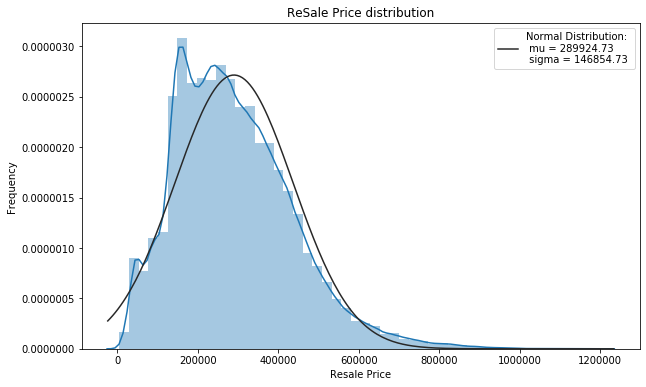

Skewness: 0.815261
Kurtosis: 1.055519


In [5]:
## Get some statistical Insights on the data
## Plot Histogram

f, ax = plt.subplots(figsize=(10, 6))

sns.distplot(flat_prices['resale_price'], fit=norm)

## Get the fitted parameters used by the function
(mu, sigma) = norm.fit(flat_prices['resale_price'])
print( '\n mu = {:.2f} and sigma = {:.2f}\n'.format(mu, sigma))

plt.legend(['Normal Distribution: \n mu = {:.2f}\n sigma = {:.2f}'.format(mu, sigma)],
            loc='best')
plt.ylabel('Frequency')
plt.xlabel('Resale Price')
plt.title('ReSale Price distribution')
plt.show()

print("Skewness: %f" % flat_prices['resale_price'].skew())
print("Kurtosis: %f" % flat_prices['resale_price'].kurt())

##### Skewness is between (-1,1) and therefore, accepted
##### Kurtosis is between (-2,2) and therefore, accepted

In [6]:
## Data Cleansing

flat_prices=flat_prices.replace({'flat_type': 'MULTI GENERATION'}, 'MULTI-GENERATION')

In [7]:
## Feature Engineering to remove numbers from street names

flat_prices['street_names'] = flat_prices.street_name.str.replace('[0-9]', '').str.strip()
flat_prices = flat_prices.drop(['street_name'], axis=1)

In [8]:
## Find Missing Ratio of Dataset
missing_data_na = (flat_prices.isnull().sum()/len(flat_prices))*100
missing_data = pd.DataFrame({'Missing Ratio': missing_data_na})
missing_data

,Missing Ratio
block,0.000000
flat_model,0.000000
flat_type,0.000000
floor_area_sqm,0.000000
lease_commence_date,0.000000
month,0.000000
remaining_lease,87.910009
resale_price,0.000000
storey_range,0.000000
town,0.000000


Text(0.5, 1.0, 'Percent missing data by feature')

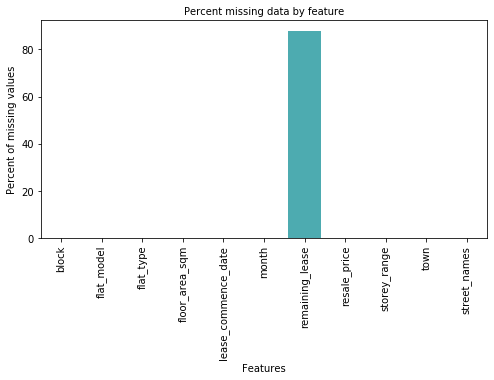

In [9]:
# Percent missing data by feature
f, ax = plt.subplots(figsize=(8, 4))
plt.xticks(rotation='90')
sns.barplot(x=missing_data_na.index, y=missing_data_na)
plt.xlabel('Features', fontsize=10)
plt.ylabel('Percent of missing values', fontsize=10)
plt.title('Percent missing data by feature', fontsize=10)

In [10]:
## Removing features whose missing percentage is higher than 50%
flat_prices = flat_prices.drop('remaining_lease', axis=1)

(0, 3)

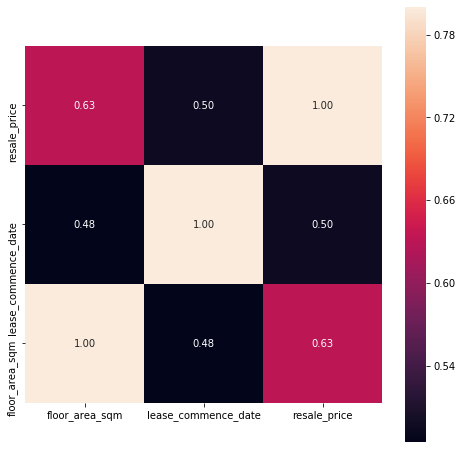

In [11]:
### Correlation between variables

## Correlation Matrix Heatmap
corrmat = flat_prices.corr()
f, ax = plt.subplots(figsize=(8, 8))
sns.heatmap(corrmat, vmax=.8, square=True, cbar=True, annot=True, fmt='.2f');

## Find the correlation among variables
flat_prices.corr(method ='pearson')
ax.set_ylim([0,3])

### Plotting Variables 

Text(0.5, 1.0, 'Resale Price by Lease Commence Date')

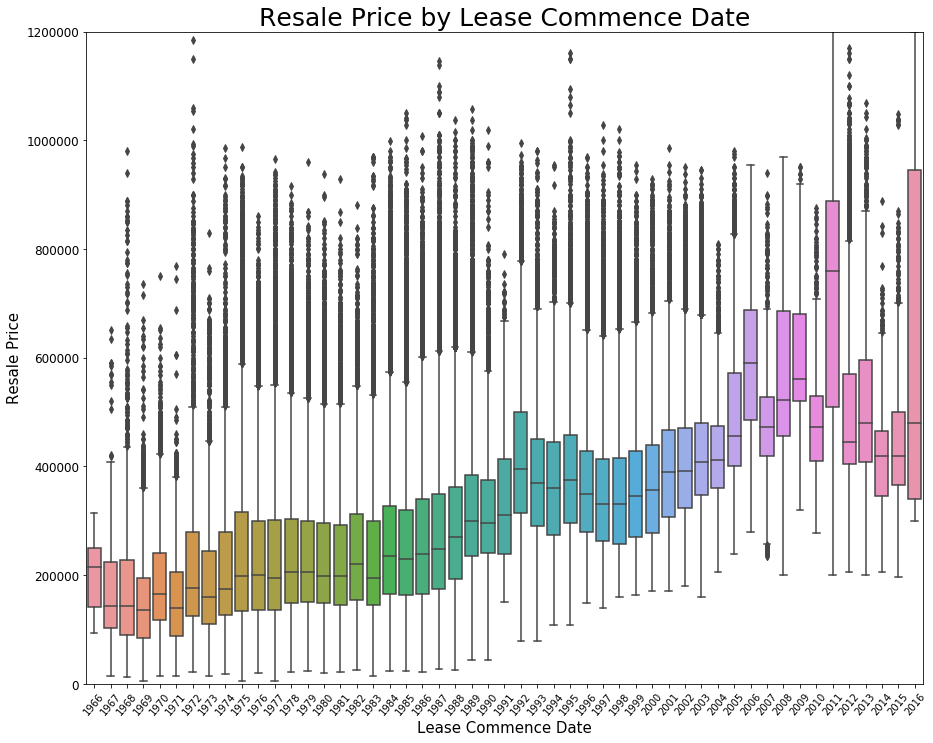

In [12]:
# Lease Commence Date vs Resale Price
data = pd.concat([flat_prices['resale_price'], flat_prices['lease_commence_date']], axis=1)
f, ax = plt.subplots(figsize=(15, 12))
fig = sns.boxplot(x='lease_commence_date', y="resale_price", data=data)
fig.axis(ymin=0, ymax=1200000);
plt.xticks(rotation='50', fontsize=10)
plt.yticks(fontsize=12)
plt.xlabel("Lease Commence Date", fontsize=15)
plt.ylabel("Resale Price", fontsize=15)
plt.title("Resale Price by Lease Commence Date", fontsize=25)

In [13]:
### Plotting Graph for Price by Floor Area Range

## Define a function to get the min and max price by given range

def priceRangeByFloor(min_range, max_range, minomax):
    if minomax == 'max':
        return ([[str(min_range) + "-" + str(max_range),
                     flat_prices['resale_price'].where((flat_prices['floor_area_sqm'] >= min_range) & (flat_prices['floor_area_sqm'] <= max_range)).max()]])
    elif minomax == 'min':
        return ([[str(min_range) + "-" + str(max_range),
                     flat_prices['resale_price'].where((flat_prices['floor_area_sqm'] >= min_range) & (flat_prices['floor_area_sqm'] <= max_range)).min()]])
    else:
        print('Incorrect Parameter')

In [14]:
## Apply above given function to a customize list

priceRangeByFloorDf=pd.DataFrame()

maxFloorSize=flat_prices['floor_area_sqm'].unique().max()

floorRange=['0-30', '31-50', '51-80', '81-120', '121-170', '171-230', '231-300', '301' + '-' + str(int(maxFloorSize))]

for a in floorRange:
    if a.find('-') != -1:
        priceRangeByFloorDf=priceRangeByFloorDf.append(priceRangeByFloor(int(a[:a.find('-')]), int(a[-(a[::-1].find('-')):]), 'min'))
        priceRangeByFloorDf=priceRangeByFloorDf.append(priceRangeByFloor(int(a[:a.find('-')]), int(a[-(a[::-1].find('-')):]), 'max'))
    elif (a.find('<') != -1):
        priceRangeByFloorDf=priceRangeByFloorDf.append(priceRangeByFloor(0, int(re.findall(r'\b\d+\b',a)[0]), 'min'))
        priceRangeByFloorDf=priceRangeByFloorDf.append(priceRangeByFloor(0, int(re.findall(r'\b\d+\b',a)[0]), 'max'))
    elif (a.find('>') != -1):
        priceRangeByFloorDf=priceRangeByFloorDf.append(priceRangeByFloor( int(re.findall(r'\b\d+\b',a)[0]), 999, 'min'))
        priceRangeByFloorDf=priceRangeByFloorDf.append(priceRangeByFloor( int(re.findall(r'\b\d+\b',a)[0]), 999, 'max'))

Text(0.5, 1.0, 'Resale Price by Floor Area Range')

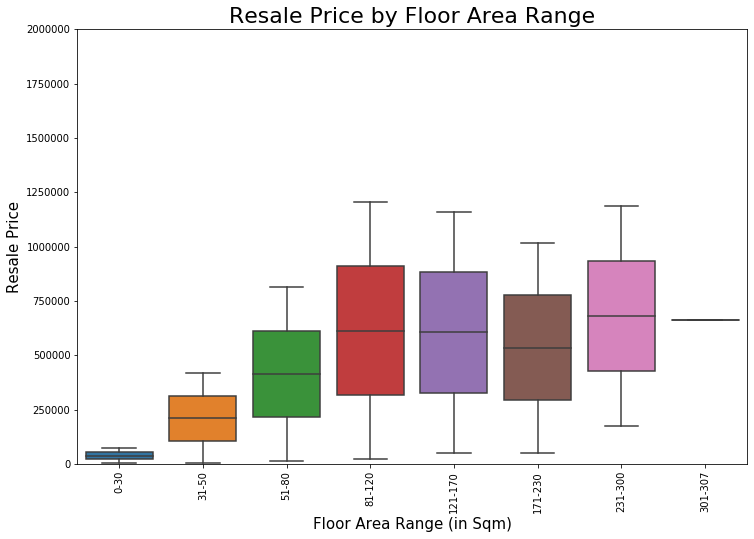

In [15]:
# Floor Area vs Resale Price
#data = pd.concat([sample[1], sample[0]], axis=1)
f, ax = plt.subplots(figsize=(12, 8))
fig = sns.boxplot(x=0, y=1, data=priceRangeByFloorDf)
fig.axis(ymin=0, ymax=2000000);
plt.xticks(rotation='90', fontsize=10)
plt.yticks(fontsize=10)
plt.xlabel("Floor Area Range (in Sqm)", fontsize=15)
plt.ylabel("Resale Price", fontsize=15)
plt.title("Resale Price by Floor Area Range", fontsize=22)

Text(0.5, 1.0, 'Resale Price by Town')

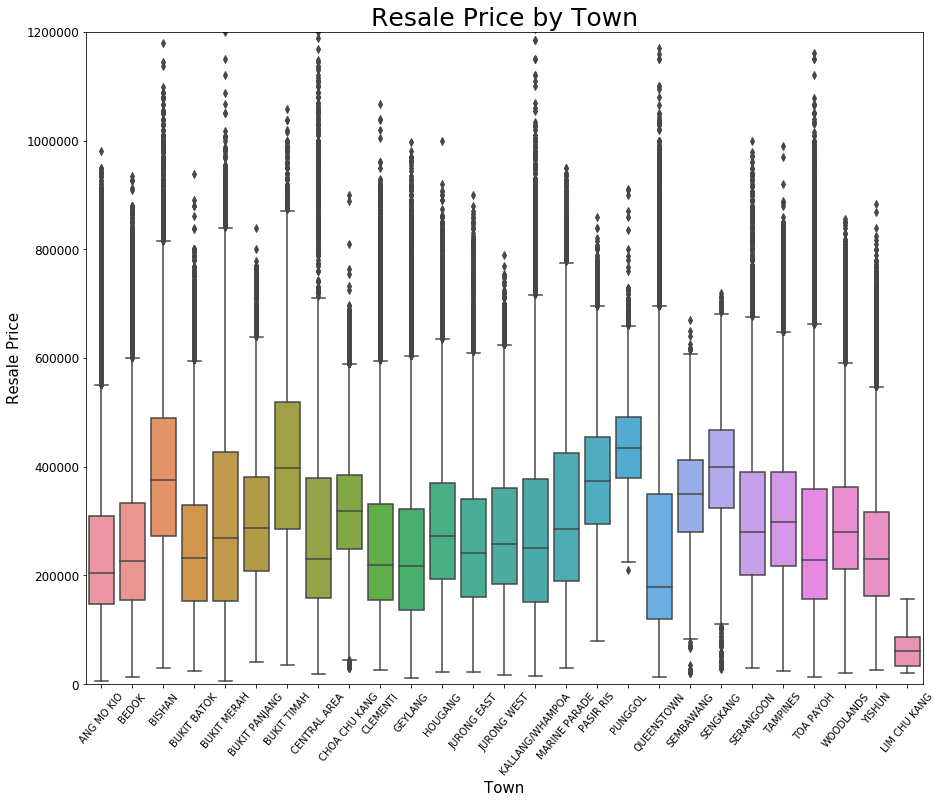

In [16]:
# Town vs Resale Price
data = pd.concat([flat_prices['resale_price'], flat_prices['town']], axis=1)
f, ax = plt.subplots(figsize=(15, 12))
fig = sns.boxplot(x='town', y="resale_price", data=data)
fig.axis(ymin=0, ymax=1200000);
plt.xticks(rotation='50', fontsize=10)
plt.yticks(fontsize=12)
plt.xlabel("Town", fontsize=15)
plt.ylabel("Resale Price", fontsize=15)
plt.title("Resale Price by Town", fontsize=25)

In [17]:
## Columns identified for Predictions but can't strings to the models
flat_prices=pd.concat([pd.DataFrame(flat_prices['flat_model'].str.lower()), 
                  flat_prices['month'].str[:4].astype(int),
                  flat_prices[['flat_type', 'floor_area_sqm', 'lease_commence_date',  
                               'resale_price', 'storey_range', 'street_names', 'town']]],axis=1).rename(columns={"month": "year"})

In [18]:
## Creating a copy of DataFrame

flat_prices_actual=flat_prices.copy()

In [19]:
## Feature engineering by calculating premiums

town_premium=(flat_prices.groupby(flat_prices.town)[['resale_price']].median()-flat_prices[['resale_price']].median()).rename(columns={"resale_price": "town_premium"}).reset_index()

flat_model_premium=(flat_prices.groupby(flat_prices.flat_model)[['resale_price']].median()-flat_prices[['resale_price']].median()).rename(columns={"resale_price": "flat_model_premium"}).reset_index()

flat_type_premium=(flat_prices.groupby(flat_prices.flat_type)[['resale_price']].median()-flat_prices[['resale_price']].median()).rename(columns={"resale_price": "flat_type_premium"}).reset_index()

street_premium=(flat_prices.groupby(flat_prices.street_names)[['resale_price']].median()-flat_prices[['resale_price']].median()).rename(columns={"resale_price": "street_names_premium"}).reset_index()

## This section will make sure to not have a duplicate premiums

distinct_town_premium = town_premium.groupby(['town_premium']).cumcount()
town_premium['town_premium']+=distinct_town_premium

distinct_flat_model_premium = flat_model_premium.groupby(['flat_model_premium']).cumcount()
flat_model_premium['flat_model_premium']+=distinct_flat_model_premium

distinct_flat_type_premium = flat_type_premium.groupby(['flat_type_premium']).cumcount()
flat_type_premium['flat_type_premium']+=distinct_flat_type_premium

distinct_street_premium = street_premium.groupby(['street_names_premium']).cumcount()
street_premium['street_names_premium']+=distinct_street_premium

## Function to create an average for storey_range

def get_mean_floor(x):
    return int((int(x[:2]) + int(x[-2:]))*0.5)

flat_prices['floor']=flat_prices['storey_range'].map(lambda storey_range: get_mean_floor(storey_range))


## Calculating Remaining lease using lease commence date and HBD had 99 years of lease

flat_prices['remaining_lease']=flat_prices['lease_commence_date'] + 99 - flat_prices['year']


In [20]:
## Applying premiums to the dataset

flat_prices=flat_prices.join(town_premium.set_index('town'), on='town').join(flat_model_premium.set_index('flat_model'), on='flat_model').join(flat_type_premium.set_index('flat_type'), on='flat_type').join(street_premium.set_index('street_names'), on='street_names').drop(['town', 'flat_model', 'flat_type', 'street_names', 'storey_range'], axis=1)

In [21]:
## Removing Duplicates

flat_prices = flat_prices.drop_duplicates()

In [22]:
## Preparing features and label for the model

X_data=flat_prices.drop(['resale_price'], axis=1)
y_data=flat_prices['resale_price']

In [23]:
## Flat Price in 2014 (to answer Question 1).

flat_prices_new=flat_prices
flat_prices_2014=flat_prices_new[flat_prices_new['year'] == 2014]
X_data_2014=flat_prices_2014.drop(['resale_price'], axis=1)
y_data_2014=flat_prices_2014['resale_price']

In [24]:
# Splitting the train and test data

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.3, random_state=4)

## Regression Models

### Model 1: Linear Regression

In [25]:
## Filename and location to save the linear model

filename_reg = os.getcwd() + '/models/regression/hbdResalePriceLinearRegModel.sav'

In [26]:
## Check if model is already loaded to local disk

if os.path.isfile(filename_reg):
    ## Reload the model from local machine
    reg=joblib.load(filename_reg)
else:
    ## Linear Model Selection and Prediction
    reg = LinearRegression()
    reg.fit(X_train, y_train)
    ## Export the model to local machine
    joblib.dump(reg, filename_reg)

In [27]:
## Predict the value using loaded model for test and 2014 dataset

reg_pred=reg.predict(X_test)
reg_pred_2014=reg.predict(X_data_2014)

In [28]:
## Data Results for test dataset

print('Regression Score: %.3f' % reg.score(X_test, y_test))

# Calculate the Root Mean Squared Error
rms = sqrt(mean_squared_error(y_test, reg_pred))
print('RMSE: %.2f' % rms)

Regression Score: 0.753
RMSE: 73215.27


Text(0.5, 1.0, 'Resale Price Predicted: Regression Model')

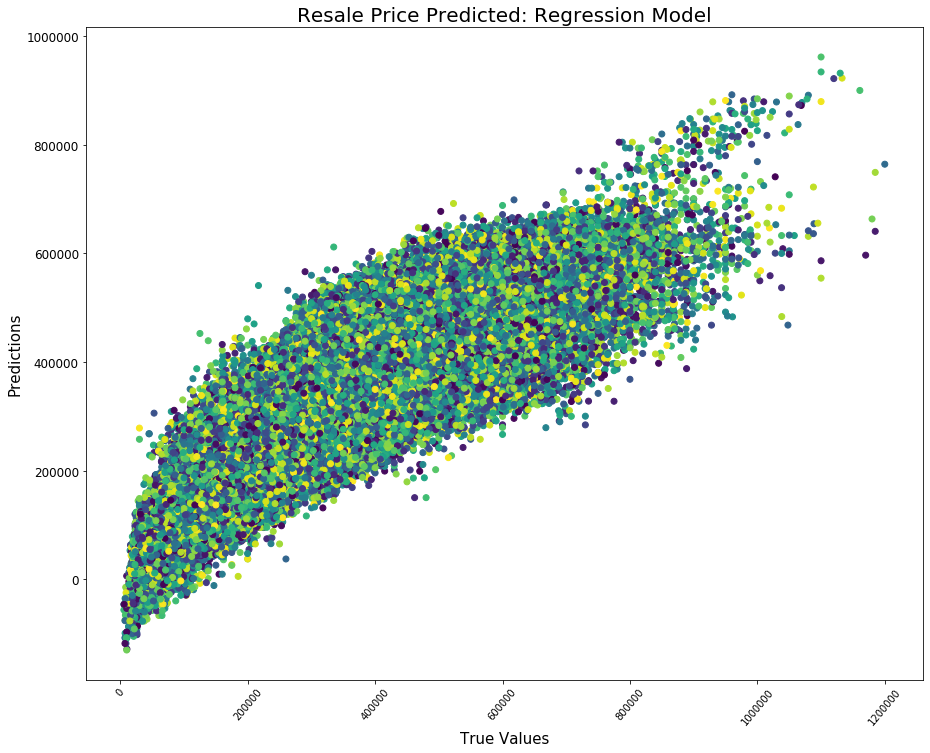

In [29]:
## Data Plot for test dataset

colors = np.random.rand(y_test.count())
plt.subplots(figsize=(15, 12))
plt.scatter(y_test, reg_pred, c=colors)
plt.xticks(rotation='50', fontsize=10)
plt.yticks(fontsize=12)
plt.xlabel("True Values", fontsize=15)
plt.ylabel("Predictions", fontsize=15)
plt.title("Resale Price Predicted: Regression Model", fontsize=20)

Text(0.5, 1.0, 'Resale Price 2014 Predicted: Regression Model')

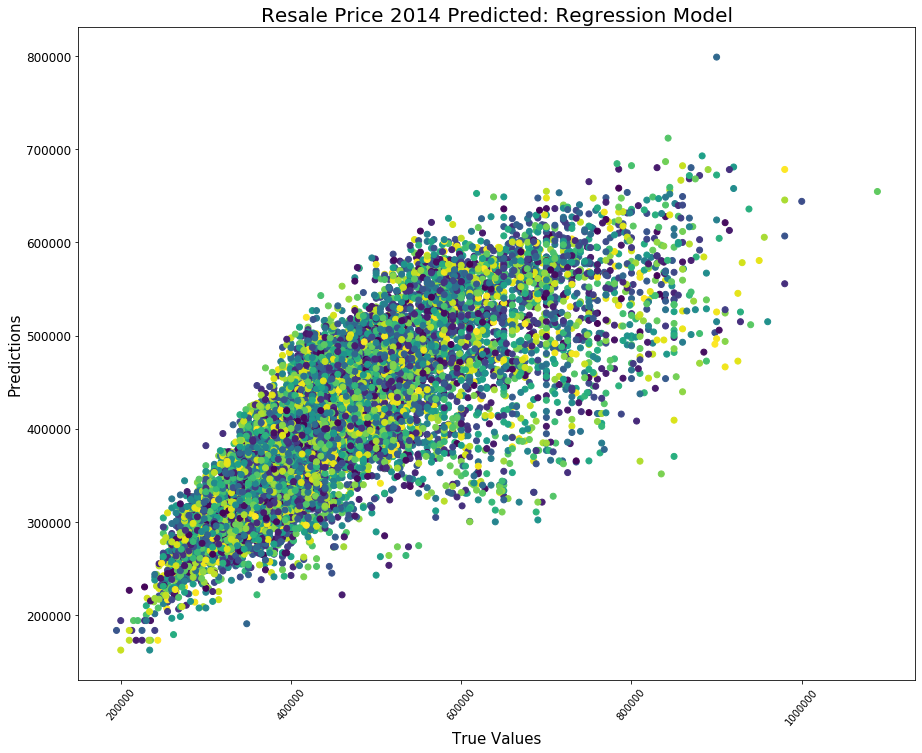

In [30]:
## Data Plot for 2014 dataset

colors = np.random.rand(y_data_2014.count())
plt.subplots(figsize=(15, 12))
plt.scatter(y_data_2014, reg_pred_2014, c=colors)
plt.xticks(rotation='50', fontsize=10)
plt.yticks(fontsize=12)
plt.xlabel("True Values", fontsize=15)
plt.ylabel("Predictions", fontsize=15)
plt.title("Resale Price 2014 Predicted: Regression Model", fontsize=20)

In [31]:
## Getting Prediction for 2014 dataset

reg_pred_df = pd.DataFrame({'Actual_Resale_Price': y_data_2014, 'Predicted_Resale_Price': reg_pred_2014})
reg_pred_df_test = reg_pred_df[['Predicted_Resale_Price']]
reg_finalPrediction=pd.merge(flat_prices_2014, reg_pred_df_test, left_index=True, right_index=True)

In [32]:
## Getting Premium corresponding values

reg_finalPrediction=reg_finalPrediction.join(town_premium.set_index('town_premium'), on='town_premium').join(flat_model_premium.set_index('flat_model_premium'), on='flat_model_premium').join(flat_type_premium.set_index('flat_type_premium'), on='flat_type_premium').join(street_premium.set_index('street_names_premium'), on='street_names_premium').drop(['town_premium', 'flat_model_premium', 'flat_type_premium', 'street_names_premium'], axis=1)

In [33]:
## Flat Price Prediction in 2014

reg_finalPrediction.head(2)

,year,floor_area_sqm,lease_commence_date,resale_price,floor,remaining_lease,Predicted_Resale_Price,town,flat_model,flat_type,street_names
36107,2014,44.0,1980,280000.0,8,65,249777.704456,ANG MO KIO,improved,2 ROOM,ANG MO KIO AVE
36108,2014,67.0,1980,290000.0,8,65,301092.213901,ANG MO KIO,new generation,3 ROOM,ANG MO KIO AVE


### Model 2: Gradient Boosting

In [34]:
## Filename and location to save the Gradient Boosting model

filename_gbr = os.getcwd() + '/models/regression/hbdResalePriceGradientBoostingModel.sav'

In [35]:
## Check if model is already loaded to local disk

if os.path.isfile(filename_gbr):
    ## Reload the model from local machine
    gbr=joblib.load(filename_gbr)
else:
    ## Using Gradient Boosting to boost the accuracy
    gbr = ensemble.GradientBoostingRegressor(n_estimators=400, max_depth=5, min_samples_split=2, learning_rate=0.1, loss='ls')
    gbr.fit(X_train, y_train)
    ## Export the model to local machine
    joblib.dump(gbr, filename_gbr)

In [36]:
## Predict the value using loaded model for test and 2014 dataset

gbr_pred = gbr.predict(X_test)
gbr_pred_2014=gbr.predict(X_data_2014)

In [37]:
## Accuracy Score with GBoost

print('Gradient Boost Score: %.3f' % gbr.score(X_test, y_test))

## Calculate Root Mean Squared Error

rms = sqrt(mean_squared_error(y_test, gbr_pred))
print('RMSE: %.2f' % rms)

Gradient Boost Score: 0.970
RMSE: 25484.04


In [38]:
## Getting Prediction for 2014 dataset

gbr_pred_df = pd.DataFrame({'Actual_Resale_Price': y_data_2014, 'Predicted_Resale_Price': gbr_pred_2014})
gbr_pred_df_test = gbr_pred_df[['Predicted_Resale_Price']]
gbr_finalPrediction=pd.merge(flat_prices_2014, gbr_pred_df_test, left_index=True, right_index=True)

In [39]:
## Getting Premium corresponding values

gbr_finalPrediction=gbr_finalPrediction.join(town_premium.set_index('town_premium'), on='town_premium').join(flat_model_premium.set_index('flat_model_premium'), on='flat_model_premium').join(flat_type_premium.set_index('flat_type_premium'), on='flat_type_premium').join(street_premium.set_index('street_names_premium'), on='street_names_premium').drop(['town_premium', 'flat_model_premium', 'flat_type_premium', 'street_names_premium'], axis=1)

In [40]:
## Flat Price Prediction in 2014

gbr_finalPrediction.head(2)

,year,floor_area_sqm,lease_commence_date,resale_price,floor,remaining_lease,Predicted_Resale_Price,town,flat_model,flat_type,street_names
36107,2014,44.0,1980,280000.0,8,65,260048.134884,ANG MO KIO,improved,2 ROOM,ANG MO KIO AVE
36108,2014,67.0,1980,290000.0,8,65,333015.558189,ANG MO KIO,new generation,3 ROOM,ANG MO KIO AVE


### Model 3: Extreme Gradient Boosting

In [41]:
## Filename and location to save the Extreme Gradient Boosting model

filename_xbg = os.getcwd() + '/models/regression/hbdResalePriceExtremeGradientBoostingModel.sav'

In [42]:
## Check if model is already loaded to local disk

if os.path.isfile(filename_xbg):
    ## Reload the model from local machine
    xgbmodel=joblib.load(filename_xbg)
else:
    ## Model Prediction using XGBoost
    xgbmodel = xgb.XGBRegressor(n_estimators=100, learning_rate=0.08, gamma=0, subsample=0.5,
                           colsample_bytree=1, max_depth=7)
    xgbmodel.fit(X_train, y_train)
    ## Export the model to local machine
    joblib.dump(xgbmodel, filename_xbg)

[11:02:21] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [43]:
## Predict the value using loaded model for test and 2014 dataset

xgb_pred= xgbmodel.predict(X_test)
xgb_pred_2014=xgbmodel.predict(X_data_2014)

In [44]:
## Accuracy Score with XGBoost

print('XGBoost Score: %.3f' % explained_variance_score(y_test, xgb_pred))
#OR
#print("XGBoost Score: %.3f" % xgbmodel.score(X_test, y_test))

## Calculate Root Mean Squared Error

rms = sqrt(mean_squared_error(y_test, xgb_pred))
print('RMSE: %.2f' % rms)

XGBoost Score: 0.964
RMSE: 27961.71


In [45]:
## Getting Prediction for 2014 dataset

xgb_pred_df = pd.DataFrame({'Actual_Resale_Price': y_data_2014, 'Predicted_Resale_Price': xgb_pred_2014})
xgb_pred_df_test = xgb_pred_df[['Predicted_Resale_Price']]
xgb_finalPrediction=pd.merge(flat_prices_2014, xgb_pred_df_test, left_index=True, right_index=True)

In [46]:
## Getting Premium corresponding values

xgb_finalPrediction=xgb_finalPrediction.join(town_premium.set_index('town_premium'), on='town_premium').join(flat_model_premium.set_index('flat_model_premium'), on='flat_model_premium').join(flat_type_premium.set_index('flat_type_premium'), on='flat_type_premium').join(street_premium.set_index('street_names_premium'), on='street_names_premium').drop(['town_premium', 'flat_model_premium', 'flat_type_premium', 'street_names_premium'], axis=1)

In [47]:
## Flat Price Prediction in 2014

xgb_finalPrediction.head(2)

,year,floor_area_sqm,lease_commence_date,resale_price,floor,remaining_lease,Predicted_Resale_Price,town,flat_model,flat_type,street_names
36107,2014,44.0,1980,280000.0,8,65,265439.50000,ANG MO KIO,improved,2 ROOM,ANG MO KIO AVE
36108,2014,67.0,1980,290000.0,8,65,333042.84375,ANG MO KIO,new generation,3 ROOM,ANG MO KIO AVE


### Model 4: KNN Clustering (Supervised for Regression)

In [48]:
## Filename and location to save the K-nearest neighbour model

filename_knn = os.getcwd() + '/models/regression/hbdResalePriceKnnModel.sav'

In [49]:
## Check if model is already loaded to local disk

if os.path.isfile(filename_knn):
    ## Reload the model from local machine
    knn=joblib.load(filename_knn)
else:
    # Run K-NN model
    knn = KNeighborsRegressor(n_neighbors=15)
    knn.fit(X_train,y_train)
    ## Export the model to local machine
    joblib.dump(knn, filename_knn)

In [50]:
## Predict the value using loaded model for test and 2014 dataset

knn_pred = knn.predict(X_test)
knn_pred_2014=knn.predict(X_data_2014)

In [51]:
## Predicting the score for KNN

print('KNN Score %.3f' % knn.score(X_test, y_test))

## RMSE the score for KNN

print('RMSE %.2f' % sqrt(mean_squared_error(y_test, knn_pred)))

KNN Score 0.955
RMSE 31125.89


In [52]:
## Getting Prediction for 2014 dataset

knn_pred_df = pd.DataFrame({'Actual_Resale_Price': y_data_2014, 'Predicted_Resale_Price': knn_pred_2014})
knn_pred_df_test = knn_pred_df[['Predicted_Resale_Price']]
knn_finalPrediction=pd.merge(flat_prices_2014, knn_pred_df_test, left_index=True, right_index=True)

In [53]:
## Getting Premium corresponding values

knn_finalPrediction=knn_finalPrediction.join(town_premium.set_index('town_premium'), on='town_premium').join(flat_model_premium.set_index('flat_model_premium'), on='flat_model_premium').join(flat_type_premium.set_index('flat_type_premium'), on='flat_type_premium').join(street_premium.set_index('street_names_premium'), on='street_names_premium').drop(['town_premium', 'flat_model_premium', 'flat_type_premium', 'street_names_premium'], axis=1)

In [54]:
## Flat Price Prediction in 2014

knn_finalPrediction.head(2)

,year,floor_area_sqm,lease_commence_date,resale_price,floor,remaining_lease,Predicted_Resale_Price,town,flat_model,flat_type,street_names
36107,2014,44.0,1980,280000.0,8,65,268200.000000,ANG MO KIO,improved,2 ROOM,ANG MO KIO AVE
36108,2014,67.0,1980,290000.0,8,65,334053.333333,ANG MO KIO,new generation,3 ROOM,ANG MO KIO AVE


#### Solution to Question 1: The best model is Gradient Boosting based on highest accuracy and lower RMSE score.




# Question 2
### Check a flat price sold in Nov 2017 which had been sold for $550,800

In [55]:
## Add the required input data. Make sure, flat_model is in lower case

flat_price_nov2017 = pd.DataFrame(columns=["year", "floor_area_sqm", "lease_commence_date", "floor", "remaining_lease", "town", "flat_model", "flat_type", "street_names"], data=[[2017, 91.0, 1984, 11, 66, 'YISHUN', 'new generation', '4 ROOM', 'YISHUN ST'], [2017, 91.0, 1984, 11, 66, 'YISHUN', 'new generation', '4 ROOM', 'YISHUN RING RD'], [2017, 91.0, 1984, 11, 66, 'YISHUN', 'new generation', '4 ROOM', 'YISHUN AVE'], [2017, 91.0, 1984, 11, 66, 'YISHUN', 'new generation', '4 ROOM', 'YISHUN CTRL']])

In [56]:
## Converting string input to number (premiums)

raw_input_data_2017=flat_price_nov2017.join(town_premium.set_index('town'), on='town').join(flat_model_premium.set_index('flat_model'), on='flat_model').join(flat_type_premium.set_index('flat_type'), on='flat_type').join(street_premium.set_index('street_names'), on='street_names')

## Dropping the actual columns which are not converted

input_data_2017=raw_input_data_2017.drop(['town', 'flat_model', 'flat_type', 'street_names'], axis=1)

In [57]:
## Using Gradient Boosting model to predict the price because of highest accuracy in Question 1

predict_2017=pd.DataFrame(gbr.predict(input_data_2017)).rename({0: "predicted_price"}, axis=1)

## Retrieve premium corresponding values
pd.merge(raw_input_data_2017, predict_2017, left_index=True, right_index=True).drop(['town_premium', 'flat_model_premium', 'flat_type_premium', 'street_names_premium'], axis=1)

,year,floor_area_sqm,lease_commence_date,floor,remaining_lease,town,flat_model,flat_type,street_names,predicted_price
0,2017,91.0,1984,11,66,YISHUN,new generation,4 ROOM,YISHUN ST,380196.038683
1,2017,91.0,1984,11,66,YISHUN,new generation,4 ROOM,YISHUN RING RD,372555.043016
2,2017,91.0,1984,11,66,YISHUN,new generation,4 ROOM,YISHUN AVE,375136.885710
3,2017,91.0,1984,11,66,YISHUN,new generation,4 ROOM,YISHUN CTRL,384582.854494


In [58]:
## Comparing data with actual results

flat_prices_actual[(flat_prices_actual['year']==2017) & (flat_prices_actual['floor_area_sqm']==91.0) & (flat_prices_actual['town']=='YISHUN') & (flat_prices_actual['lease_commence_date']==1984) & (flat_prices_actual['storey_range']=='10 TO 12')]

,flat_model,year,flat_type,floor_area_sqm,lease_commence_date,resale_price,storey_range,street_names,town
341631,new generation,2017,4 ROOM,91.0,1984,410000.0,10 TO 12,YISHUN ST,YISHUN
347304,new generation,2017,4 ROOM,91.0,1984,388000.0,10 TO 12,YISHUN ST,YISHUN
347312,new generation,2017,4 ROOM,91.0,1984,411888.0,10 TO 12,YISHUN ST,YISHUN


#### Conclusion: Resale price was overpriced where actual price must be around $400,000

# Question 3
### Classification Problem to get flat type for the same dataset
#### This is a multi classification problem and we will use 4 models to predict the flat type

In [59]:
## Create a DataFrame copy for later use

flat_types=flat_prices_actual.copy()

Text(0, 0.5, 'Sample Size')

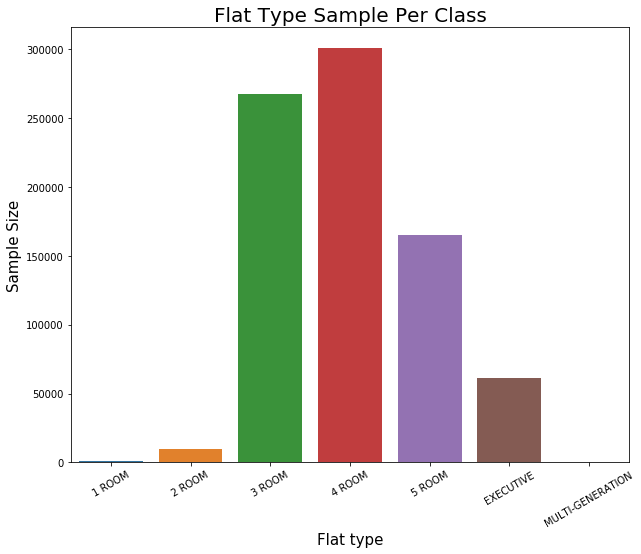

In [60]:
## Check how many samples are available per flat type class

sample_per_class=flat_types.groupby(flat_types.flat_type)[['flat_type']].count()

f, ax = plt.subplots(figsize=(10, 8))
plt.xticks(rotation=30)
plt.title("Flat Type Sample Per Class", size=20)
sns.barplot(x=sample_per_class.index, y=sample_per_class.flat_type)
plt.xlabel("Flat type", size=15)
plt.ylabel("Sample Size", size=15)

In [61]:
## Feature engineering by calculating premiums

town_premium=(flat_types.groupby(flat_types.town)[['resale_price']].median()-flat_types[['resale_price']].median()).rename(columns={"resale_price": "town_premium"}).reset_index()

flat_model_premium=(flat_types.groupby(flat_types.flat_model)[['resale_price']].median()-flat_types[['resale_price']].median()).rename(columns={"resale_price": "flat_model_premium"}).reset_index()

street_premium=(flat_types.groupby(flat_types.street_names)[['resale_price']].median()-flat_types[['resale_price']].median()).rename(columns={"resale_price": "street_names_premium"}).reset_index()

## This section will make sure to not have a duplicate premiums

distinct_town_premium = town_premium.groupby(['town_premium']).cumcount()
town_premium['town_premium']+=distinct_town_premium

distinct_flat_model_premium = flat_model_premium.groupby(['flat_model_premium']).cumcount()
flat_model_premium['flat_model_premium']+=distinct_flat_model_premium

distinct_street_premium = street_premium.groupby(['street_names_premium']).cumcount()
street_premium['street_names_premium']+=distinct_street_premium

## Function to create an average for storey_range
def get_mean_floor(x):
    return int((int(x[:2]) + int(x[-2:]))*0.5)

flat_types['floor']=flat_types['storey_range'].map(lambda storey_range: get_mean_floor(storey_range))


## Calculating Remaining lease using lease commence date and HBD had 99 years of lease
flat_types['remaining_lease']=flat_types['lease_commence_date'] + 99 - flat_types['year']


In [62]:
## Applying premiums to the dataset

flat_types=flat_types.join(town_premium.set_index('town'), on='town').join(flat_model_premium.set_index('flat_model'), on='flat_model').join(street_premium.set_index('street_names'), on='street_names').drop(['town', 'flat_model', 'street_names', 'storey_range'], axis=1)

In [63]:
## Removing Duplicates

flat_types=flat_types.drop_duplicates()

In [64]:
## Preparing features and label for the model

X_data_ft=flat_types.drop(['flat_type'], axis=1)
y_data_ft=flat_types['flat_type']

In [65]:
## Splitting Train and Test dataset

X_train_ft, X_test_ft, y_train_ft, y_test_ft = train_test_split(X_data_ft, y_data_ft, test_size=0.3, random_state=4)

## Classification Models

### Model 1: Logistic Regression

In [66]:
## Filename and location to save the logistic regression model

filename_logreg = os.getcwd() + '/models/classification/hbdFlatTypeLogRegModel.sav'

In [67]:
## Check if model is already loaded to local disk

if os.path.isfile(filename_logreg):
    ## Reload the model from local machine
    logreg=joblib.load(filename_logreg)
else:
    ## Linear Model Selection and Prediction
    logreg = LogisticRegression()
    logreg.fit(X_train_ft, y_train_ft)
    ## Export the model to local machine
    joblib.dump(logreg, filename_logreg)

In [68]:
## Predict the values on test dataset

logreg_predict=logreg.predict(X_test_ft)

In [69]:
## Accuracy Score with Logistic Regression

print('Logistic Score: %.3f' % logreg.score(X_test_ft, y_test_ft), '\n')
#OR
#print('Logistic Score: %.3f' % metrics.accuracy_score(y_test_ft, logreg_predict))

## Miss Classification count

count_misclassified = (y_test_ft != logreg_predict).sum()
print('Misclassified samples (in %): {:.2f}'.format(count_misclassified/y_test_ft.count()*100), '\n')

print('Classification Report by Flat Type:\n', metrics.classification_report(y_test_ft, logreg_predict))

Logistic Score: 0.596 

Misclassified samples (in %): 40.38 



/Users/sakhuja/opt/anaconda3/envs/skillsml/lib/python3.6/site-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Classification Report by Flat Type:
                   precision    recall  f1-score   support

          1 ROOM       0.35      0.24      0.28       314
          2 ROOM       0.00      0.00      0.00      2719
          3 ROOM       0.65      0.73      0.69     72689
          4 ROOM       0.53      0.68      0.60     85264
          5 ROOM       0.61      0.20      0.30     47531
       EXECUTIVE       0.71      0.83      0.77     17838
MULTI-GENERATION       0.01      0.01      0.01       153

        accuracy                           0.60    226508
       macro avg       0.41      0.38      0.38    226508
    weighted avg       0.59      0.60      0.57    226508



(0, 7)

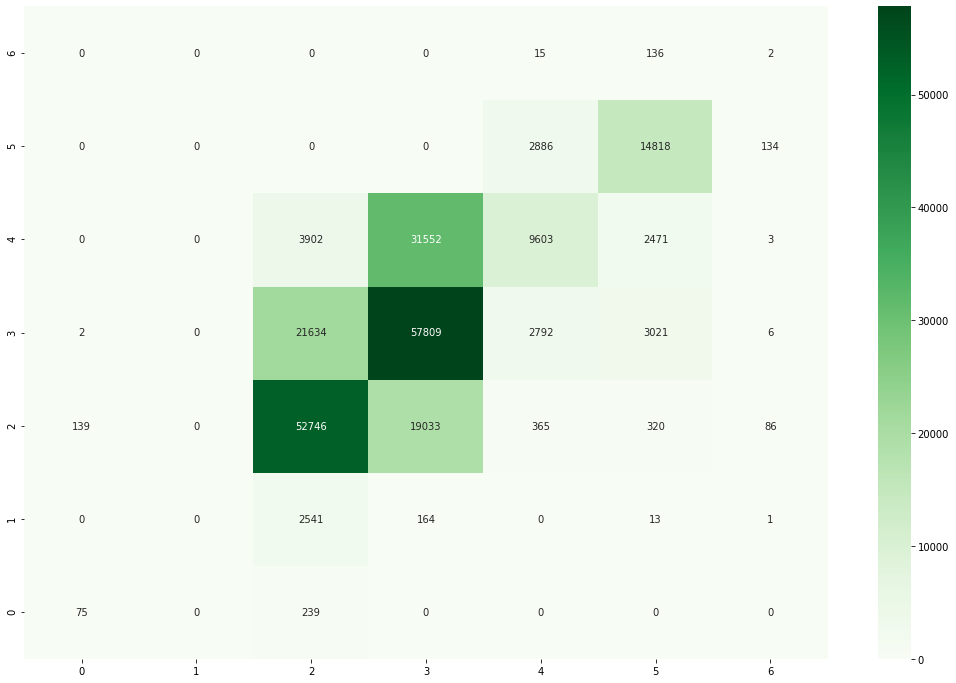

In [70]:
## Confusion Matrix

fig, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(metrics.confusion_matrix(y_test_ft, logreg_predict), annot=True, cmap='Greens', fmt='g')
ax.set_ylim([0,7])

### Model 2: Naive Bayes

In [71]:
## Filename and location to save the Naive Bayes model

filename_nb = os.getcwd() + '/models/classification/hbdFlatTypeNaiveBayesModel.sav'

In [72]:
## Check if model is already loaded to local disk

if os.path.isfile(filename_nb):
    ## Reload the model from local machine
    nb=joblib.load(filename_nb)
else:
    ## Linear Model Selection and Prediction
    nb = GaussianNB()
    nb.fit(X_train_ft, y_train_ft)
    ## Export the model to local machine
    joblib.dump(nb, filename_nb)

In [73]:
## Predict the values on test dataset

nb_predict=nb.predict(X_test_ft)

In [74]:
## Accuracy Score with Naive Bayes

print('Naive Bayes Score: %.3f\n' % nb.score(X_test_ft, y_test_ft), '\n')

## Miss Classification count

count_misclassified = (y_test_ft != nb_predict).sum()
print('Misclassified samples (in %): {:.2f}\n'.format(count_misclassified/y_test_ft.count()*100), '\n')

print('Classification Report by Flat Type:\n', metrics.classification_report(y_test_ft, nb_predict))

Naive Bayes Score: 0.917
 

Misclassified samples (in %): 8.29
 

Classification Report by Flat Type:
                   precision    recall  f1-score   support

          1 ROOM       0.41      1.00      0.58       314
          2 ROOM       0.79      0.67      0.72      2719
          3 ROOM       0.88      0.96      0.92     72689
          4 ROOM       0.95      0.85      0.90     85264
          5 ROOM       0.92      0.96      0.94     47531
       EXECUTIVE       1.00      0.95      0.97     17838
MULTI-GENERATION       1.00      1.00      1.00       153

        accuracy                           0.92    226508
       macro avg       0.85      0.91      0.86    226508
    weighted avg       0.92      0.92      0.92    226508



(0, 7)

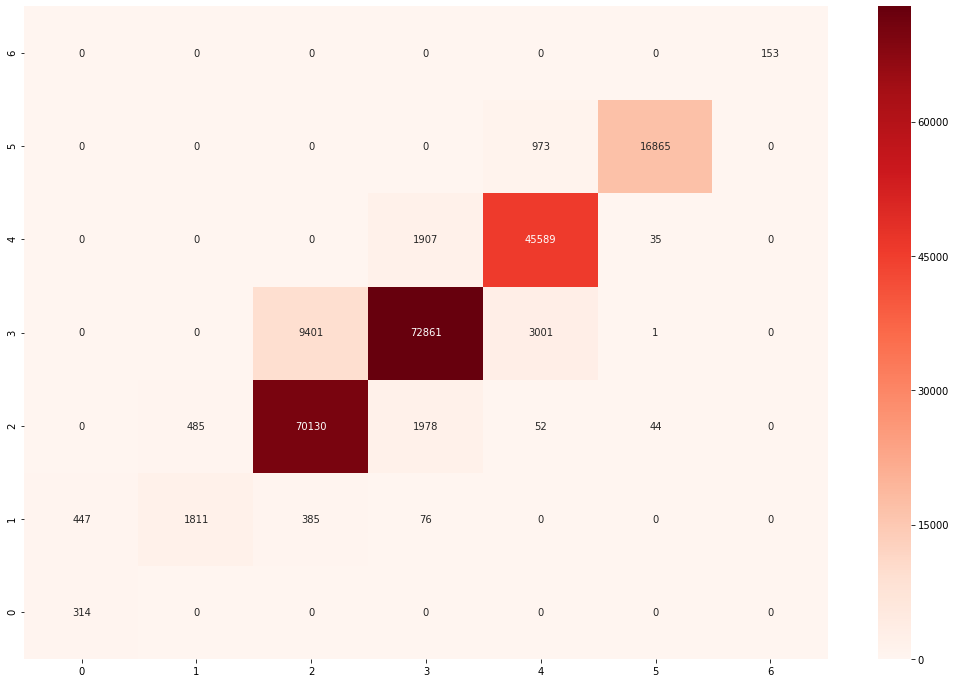

In [75]:
## Confusion Matrix

fig, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(metrics.confusion_matrix(y_test_ft, nb_predict), annot=True, cmap='Reds', fmt='g')
ax.set_ylim([0,7])

### Model 3: SVM 

#### This model may takes over 2.5 hours with Mac dual-core Intel i5 precessor

In [76]:
## Filename and location to save the SVM model

filename_svm = os.getcwd() + '/models/classification/hbdFlatTypeSVMModel.sav'

In [77]:
## Check if model is already loaded to local disk

if os.path.isfile(filename_svm):
    ## Reload the model from local machine
    svm=joblib.load(filename_svm)
else:
    ## Linear Model Selection and Prediction
    svm = svm.SVC(decision_function_shape='ovo')
    svm.fit(X_train_ft, y_train_ft)
    ## Export the model to local machine
    joblib.dump(svm, filename_svm)

In [78]:
## Predict the values on test dataset

svm_predict=svm.predict(X_test_ft)

In [79]:
## Accuracy Score with SVM

print('SVM Score: %.3f\n' % svm.score(X_test_ft, y_test_ft), '\n')

## Miss Classification count

count_misclassified = (y_test_ft != svm_predict).sum()
print('Misclassified samples (in %): {:.2f}\n'.format(count_misclassified/y_test_ft.count()*100), '\n')

print('Classification Report by Flat Type:\n', metrics.classification_report(y_test_ft, svm_predict))

SVM Score: 0.783
 

Misclassified samples (in %): 21.67
 

Classification Report by Flat Type:
                   precision    recall  f1-score   support

          1 ROOM       1.00      0.19      0.32       314
          2 ROOM       0.92      0.07      0.13      2719
          3 ROOM       0.73      0.76      0.74     72689
          4 ROOM       0.77      0.80      0.78     85264
          5 ROOM       0.84      0.78      0.81     47531
       EXECUTIVE       0.98      0.94      0.96     17838
MULTI-GENERATION       0.00      0.00      0.00       153

        accuracy                           0.78    226508
       macro avg       0.75      0.51      0.53    226508
    weighted avg       0.79      0.78      0.78    226508



(0, 7)

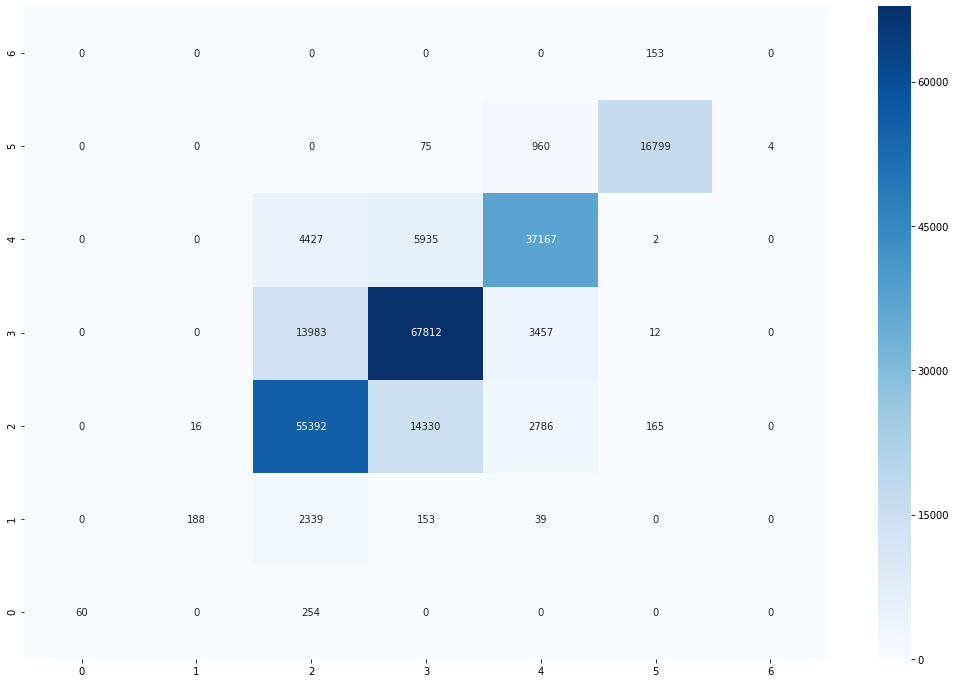

In [80]:
## Confusion Matrix

fig, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(metrics.confusion_matrix(y_test_ft, svm_predict), annot=True, cmap='Blues', fmt='g')
ax.set_ylim([0,7])

### Model 4: KNN Clustering (Supervised for MultiClass Classification)

In [81]:
## Create a copy for dataframe to not overwrite originial

flat_types_int=flat_types.copy()

In [82]:
## Feature engineering for flat type column

flat_type_premium=(flat_types_int.groupby(flat_types_int.flat_type)[['resale_price']].median()-flat_types_int[['resale_price']].median()).rename(columns={"resale_price": "flat_type_premium"}).reset_index()

## This section will make sure to not have a duplicate premiums

distinct_flat_type_premium = flat_type_premium.groupby(['flat_type_premium']).cumcount()
flat_type_premium['flat_type_premium']+=distinct_flat_type_premium

In [83]:
## Applying premiums to the dataset

flat_types_int=flat_types_int.join(flat_type_premium.set_index('flat_type'), on='flat_type').drop(['flat_type'], axis=1)

In [84]:
## Preparing features and label for the model

X_data_ft_int=flat_types_int.drop(['flat_type_premium'], axis=1)
y_data_ft_int=flat_types_int['flat_type_premium']

In [85]:
## Splitting Train and Test dataset

X_train_ft_int, X_test_ft_int, y_train_ft_int, y_test_ft_int = train_test_split(X_data_ft_int, y_data_ft_int, test_size=0.3, random_state=4)

In [86]:
## Filename and location to save the K-Nearest Neighbour model

filename_knn_class = os.getcwd() + '/models/classification/hbdFlatTypeKnnClassModel.sav'

In [87]:
## Check if model is already loaded to local disk

if os.path.isfile(filename_knn_class):
    ## Reload the model from local machine
    knn_class=joblib.load(filename_knn_class)
else:
    # Run K-NN model
    knn_class = KNeighborsClassifier(n_neighbors=15)
    knn_class.fit(X_train_ft_int,y_train_ft_int)
    ## Export the model to local machine
    joblib.dump(knn_class, filename_knn_class)

In [88]:
## Prediction on test dataset

knn_class_pred = knn_class.predict(X_test_ft_int)

In [89]:
## Predicting the score

print('KNN Class Score %.3f' % knn_class.score(X_test_ft_int, y_test_ft_int))

KNN Class Score 0.893


(0, 7)

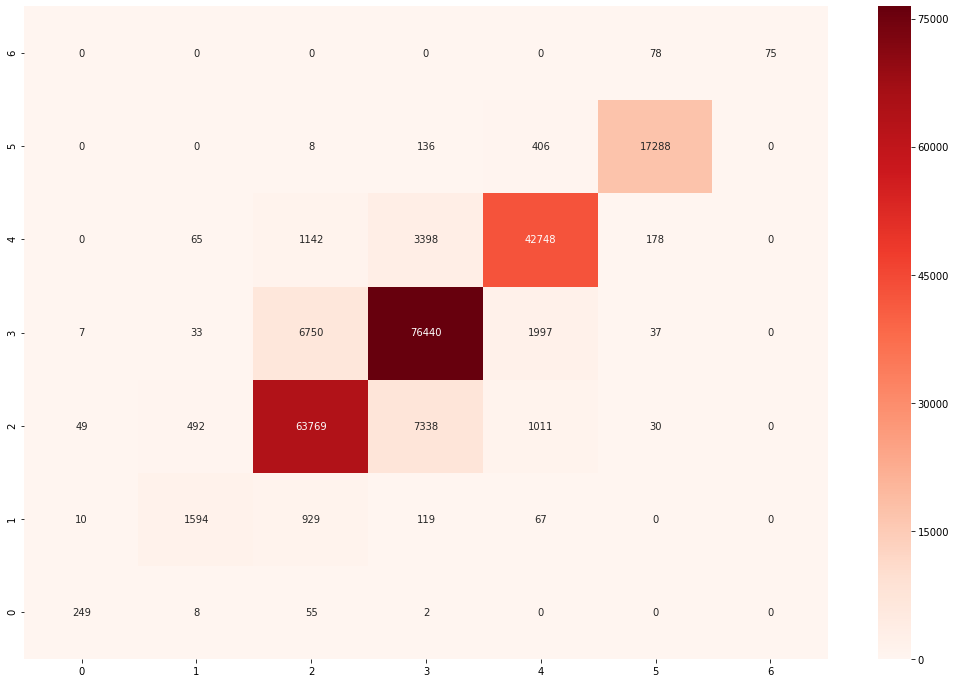

In [90]:
## Confusion Matrix

fig, ax = plt.subplots(figsize=(18, 12))
sns.heatmap(metrics.confusion_matrix(y_test_ft_int, knn_class_pred), annot=True, cmap='Reds', fmt='g')
ax.set_ylim([0,7])

#### Conclusion for Question 3: Highest accuracy is delivered by Naive Bayes Model

#### Using Naive Bayes to predict Flat Type

In [91]:
## Getting Input dataframe ready to predict data flat types

predict_flat_type=flat_types.copy()
predict_flat_type=predict_flat_type.drop('flat_type', axis=1)
predict_flat_type['predicted_flat_type']=nb.predict(predict_flat_type)

In [92]:
## Getting Premium corresponding values

final_flat_type_prediction=predict_flat_type.join(town_premium.set_index('town_premium'), on='town_premium').join(flat_model_premium.set_index('flat_model_premium'), on='flat_model_premium').join(street_premium.set_index('street_names_premium'), on='street_names_premium').drop(['town_premium', 'flat_model_premium', 'street_names_premium'], axis=1)

In [93]:
## Final Predicted Flat Types with an accuracy of 91.7%

final_flat_type_prediction

,year,floor_area_sqm,lease_commence_date,resale_price,floor,remaining_lease,predicted_flat_type,town,flat_model,street_names
0,2012,45.0,1986,250000.0,8,73,3 ROOM,ANG MO KIO,improved,ANG MO KIO AVE
1,2012,44.0,1980,265000.0,3,67,3 ROOM,ANG MO KIO,improved,ANG MO KIO AVE
2,2012,68.0,1980,315000.0,8,67,3 ROOM,ANG MO KIO,new generation,ANG MO KIO AVE
3,2012,67.0,1984,320000.0,3,71,3 ROOM,ANG MO KIO,new generation,ANG MO KIO AVE
4,2012,67.0,1980,321000.0,8,67,3 ROOM,ANG MO KIO,new generation,ANG MO KIO AVE
...,...,...,...,...,...,...,...,...,...,...
806563,2016,112.0,2000,488000.0,14,83,5 ROOM,YISHUN,improved,YISHUN ST
806564,2016,122.0,1987,455000.0,2,70,5 ROOM,YISHUN,improved,YISHUN ST
806565,2016,181.0,1992,778000.0,11,75,EXECUTIVE,YISHUN,apartment,YISHUN AVE
806566,2016,146.0,1988,575000.0,2,71,EXECUTIVE,YISHUN,maisonette,YISHUN CTRL
